<a href="https://colab.research.google.com/github/Mr1-Robot/machine-learning-alternative-assessment/blob/main/alternative_assessment_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Alternative Assessment - WOA7015
#####MUAAMAR MOHAMMED ABDULLAH AL-GHRAIRI - 24084470

In [1]:
# Mount google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/alternative-assessment-materials/"
IMAGE_DIR = f"{DATA_ROOT}VQA_RAD_Images"
ANNOTATION_FILE = f"{DATA_ROOT}VQA_RAD_Dataset.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data processing
import pandas as pd
import numpy as np
from PIL import Image
import json
import os

# Utilities
from tqdm import tqdm
import matplotlib.pyplot as plt

print("-"*30)
print("SETUP")
print("-"*30)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("-"*30)

------------------------------
SETUP
------------------------------
PyTorch Version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Using device: cuda
------------------------------


Load & Explore **Dataset**

In [ ]:
# Load dataset
vqa_data = pd.read_json(ANNOTATION_FILE)

print(f"Total Q&A pairs: {len(vqa_data)}")
print(f"Columns: {vqa_data.columns.tolist()}")

# Answer type distribution
answer_types = vqa_data['answer_type'].value_counts()
print("\nAnswer Type Distribution:")
for k, v in answer_types.items():
    print(f"{k}: {v} ({v/len(vqa_data)*100:.1f}%)")

# Closed-ended questions
closed_data = vqa_data[vqa_data['answer_type'] == 'CLOSED'].copy()
print(f"\nClosed-ended questions: {len(closed_data)}")

# Normalize answers
closed_data['answer_norm'] = closed_data['answer'].str.lower().str.strip()

# Yes/No distribution
yn_dist = closed_data['answer_norm'].value_counts()
print("\nYes/No Distribution:")
for ans, count in yn_dist.items():
    print(f"{ans}: {count} ({count/len(closed_data)*100:.1f}%)")

# Organ distribution
organ_dist = vqa_data['image_organ'].value_counts()
print("\nImage Organ Distribution:")
for organ, count in organ_dist.items():
    print(f"{organ}: {count} ({count/len(vqa_data)*100:.1f}%)")

Total Q&A pairs: 2248
Columns: ['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type']

Answer Type Distribution:
CLOSED: 1297 (57.7%)
OPEN: 949 (42.2%)
CLOSED : 2 (0.1%)

Closed-ended questions: 1297

Yes/No Distribution:
no: 606 (46.7%)
yes: 586 (45.2%)
flair: 5 (0.4%)
pa: 4 (0.3%)
left: 4 (0.3%)
white matter: 3 (0.2%)
diffuse: 3 (0.2%)
female: 3 (0.2%)
with contrast: 3 (0.2%)
mri: 3 (0.2%)
right: 3 (0.2%)
normal: 3 (0.2%)
hyperintense: 3 (0.2%)
abnormal: 3 (0.2%)
heterogeneous: 3 (0.2%)
right side: 2 (0.2%)
solid: 2 (0.2%)
cystic: 2 (0.2%)
ct: 2 (0.2%)
asymmetric: 2 (0.2%)
both: 2 (0.2%)
gray matter: 2 (0.2%)
pleural effusion: 2 (0.2%)
bilateral: 2 (0.2%)
contrast: 2 (0.2%)
less dense: 2 (0.2%)
left side: 2 (0.2%)
medical process: 2 (0.2%)
small bowel: 1 (0.1%)
the surrounding tissue: 1 (0.1%)
more dense: 1 (0.1%)
left kidney:

**Constructing Binary (Yes/No) Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

print("-"*30)
print("Constructing Binary (Yes/No) Dataset")
print("-"*30)

# 1. Filter CLOSED-ended questions
closed_data = vqa_data[vqa_data['answer_type'].str.strip() == 'CLOSED'].copy()

# 2. Normalize answers
closed_data['answer_norm'] = closed_data['answer'].str.lower().str.strip()

# 3. Keep ONLY true binary answers
binary_data = closed_data[closed_data['answer_norm'].isin(['yes', 'no'])].copy()

print(f"Total CLOSED questions: {len(closed_data)}")
print(f"Binary Yes/No questions: {len(binary_data)}")

# 4. Map labels explicitly
binary_data['label'] = binary_data['answer_norm'].map({'no': 0, 'yes': 1})

print(f"Yes: {binary_data['label'].sum()}, "
      f"No: {len(binary_data) - binary_data['label'].sum()}")

# 5. Set random seed
np.random.seed(42)

# 6. Train / Test split (15% test)
train_val, test = train_test_split(
    binary_data,
    test_size=0.15,
    random_state=42,
    stratify=binary_data['label']
)

# 7. Train / Val split (15% of total)
train, val = train_test_split(
    train_val,
    test_size=0.176,  # 0.15 / 0.85
    random_state=42,
    stratify=train_val['label']
)

# 8. Reset indices
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

print("\nSplit sizes:")
print(f"  Train: {len(train)} ({len(train)/len(binary_data)*100:.1f}%)")
print(f"  Val:   {len(val)} ({len(val)/len(binary_data)*100:.1f}%)")
print(f"  Test:  {len(test)} ({len(test)/len(binary_data)*100:.1f}%)")

print("\nClass distribution:")
print(f"  Train - Yes: {train['label'].sum()}, No: {len(train)-train['label'].sum()}")
print(f"  Val   - Yes: {val['label'].sum()}, No: {len(val)-val['label'].sum()}")
print(f"  Test  - Yes: {test['label'].sum()}, No: {len(test)-test['label'].sum()}")

print("-"*30)

# 9. Save split IDs (stable identifiers)
os.makedirs(f"{DATA_ROOT}", exist_ok=True)

split_ids = {
    'train_qids': train['qid'].tolist(),
    'val_qids': val['qid'].tolist(),
    'test_qids': test['qid'].tolist()
}

with open(f"{DATA_ROOT}split_qids.json", "w") as f:
    json.dump(split_ids, f)

print(f"Split QIDs saved to: {DATA_ROOT}split_qids.json")

------------------------------
Constructing Binary (Yes/No) Dataset
------------------------------
Total CLOSED questions: 1299
Binary Yes/No questions: 1193
Yes: 587, No: 606

Split sizes:
  Train: 835 (70.0%)
  Val:   179 (15.0%)
  Test:  179 (15.0%)

Class distribution:
  Train - Yes: 411, No: 424
  Val   - Yes: 88, No: 91
  Test  - Yes: 88, No: 91
------------------------------
Split QIDs saved to: /content/drive/MyDrive/alternative-assessment-materials/split_qids.json


###**Create PyTorch Dataset**

In [ ]:
from torchvision import transforms

class VQADataset(Dataset):
    """
    Dataset returning:
      - image tensor
      - raw question string
      - binary label
    """

    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Load image
        image_path = os.path.join(self.image_dir, row['image_name'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Raw question (string)
        question = row['question']

        # Binary label
        label = torch.tensor(row['label'], dtype=torch.long)

        return image, question, label


# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Standard for ResNet
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],           # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

# Create Dataset Objects
train_dataset = VQADataset(train, IMAGE_DIR, transform=transform)
val_dataset   = VQADataset(val, IMAGE_DIR, transform=transform)
test_dataset  = VQADataset(test, IMAGE_DIR, transform=transform)

print("-" * 30)
print("Datasets Created")
print("-" * 30)
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")
print("-" * 30)

# One Sample
sample_image, sample_question, sample_label = train_dataset[0]

print("Sample item check:")
print(f"  Image shape: {sample_image.shape}")
print(f"  Question: {sample_question}")
print(f"  Label: {sample_label.item()}")
print("-" * 30)

------------------------------
Datasets Created
------------------------------
Train samples: 835
Val samples:   179
Test samples:  179
------------------------------
Sample item check:
  Image shape: torch.Size([3, 224, 224])
  Question: Is the heart enlarged?
  Label: 0
------------------------------


**Create Dataloaders**

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,        # Shuffle only training data
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("-" * 30)
print("Dataloaders Created")
print("-" * 30)
print(f"Train batches: {len(train_loader)} (batch size = {BATCH_SIZE})")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")
print("-" * 30)

# Inspect One Batch
sample_batch = next(iter(train_loader))
batch_images, batch_questions, batch_labels = sample_batch

print("Sample batch inspection:")
print(f"  Images tensor shape: {batch_images.shape}")      # [B, 3, 224, 224]
print(f"  Number of questions: {len(batch_questions)}")    # B
print(f"  Example question: {batch_questions[0]}")
print(f"  Labels tensor shape: {batch_labels.shape}")      # [B]
print("-" * 30)

------------------------------
Dataloaders Created
------------------------------
Train batches: 27 (batch size = 32)
Val batches:   6
Test batches:  6
------------------------------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Sample batch inspection:
  Images tensor shape: torch.Size([32, 3, 224, 224])
  Number of questions: 32
  Example question: Is there a midline shift?
  Labels tensor shape: torch.Size([32])
------------------------------


###**CNN Model Architecture (ResNet18)**

In [ ]:
from torchvision import models

class CNNBaseline(nn.Module):
    def __init__(self, num_classes=2, dropout=0.3, fine_tune=True):
        super().__init__()

        self.backbone = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1
        )

        # Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Optionally unfreeze last block for fine-tuning
        if fine_tune:
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True

        # Replace classification head
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, images):
        return self.backbone(images)

####**Training & Evaulation functions**

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train CNN baseline for one epoch (vision-only)."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, _, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass (image only)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate CNN baseline (vision-only)."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, _, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


print("-" * 30)
print("CNN TRAINING FUNCTIONS DEFINED")
print("-" * 30)

------------------------------
CNN TRAINING FUNCTIONS DEFINED
------------------------------


**Train CNN Baseline Model**

In [ ]:
model = CNNBaseline(
    num_classes=2,
    dropout=0.3,
    fine_tune=True
).to(device)

# Training configuration
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
PATIENCE = 3 # Stop if no improvements for 3 epochs

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

# Track training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Track best model by val_loss
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

print("-"*30)
print("Training CNN Baseline Model")
print("-"*30)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Optimizer: Adam")
print("-"*30)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model based on val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'history': history,
        }, f'{DATA_ROOT}/cnn_best_model.pth')

        print(f"Best model saved (Val Loss improved: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement (Patience: {patience_counter}/{PATIENCE})")

        # Early stopping
        if patience_counter >= PATIENCE:
            print(f"\n{'='*50}")
            print(f"Early stopping triggered at epoch {epoch}")
            print(f"Best model from epoch {best_epoch}")
            print(f"Best val_loss: {best_val_loss:.4f}")
            print(f"{'='*50}")
            break

print("\n" + "-"*50)
print("Training Completed!")
print("-"*50)
print(f"Best epoch: {best_epoch}")
print(f"Best val_loss: {best_val_loss:.4f}")
print(f"Total epochs trained: {len(history['train_loss'])}")
print("-"*50)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


------------------------------
Training CNN Baseline Model
------------------------------
Epochs: 10
Learning rate: 0.0001
Optimizer: Adam
------------------------------

Epoch 1/10
------------------------------


Training:   0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


Train Loss: 0.6865 | Train Acc: 62.28%
Val Loss: 0.7694 | Val Acc: 59.22%
Best model saved (Val Loss improved: 0.7694)

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


Train Loss: 0.4949 | Train Acc: 76.65%
Val Loss: 0.6663 | Val Acc: 66.48%
Best model saved (Val Loss improved: 0.6663)

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 6/6 [00:17<00:00,  2.97s/it]


Train Loss: 0.4539 | Train Acc: 77.72%
Val Loss: 0.7077 | Val Acc: 67.60%
No improvement (Patience: 1/3)

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


Train Loss: 0.5016 | Train Acc: 77.96%
Val Loss: 0.8329 | Val Acc: 62.57%
No improvement (Patience: 2/3)

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]

Train Loss: 0.4297 | Train Acc: 77.13%
Val Loss: 0.7797 | Val Acc: 65.36%
No improvement (Patience: 3/3)

Early stopping triggered at epoch 5
Best model from epoch 2
Best val_loss: 0.6663

--------------------------------------------------
Training Completed!
--------------------------------------------------
Best epoch: 2
Best val_loss: 0.6663
Total epochs trained: 5
--------------------------------------------------


**Ploting the Curves**

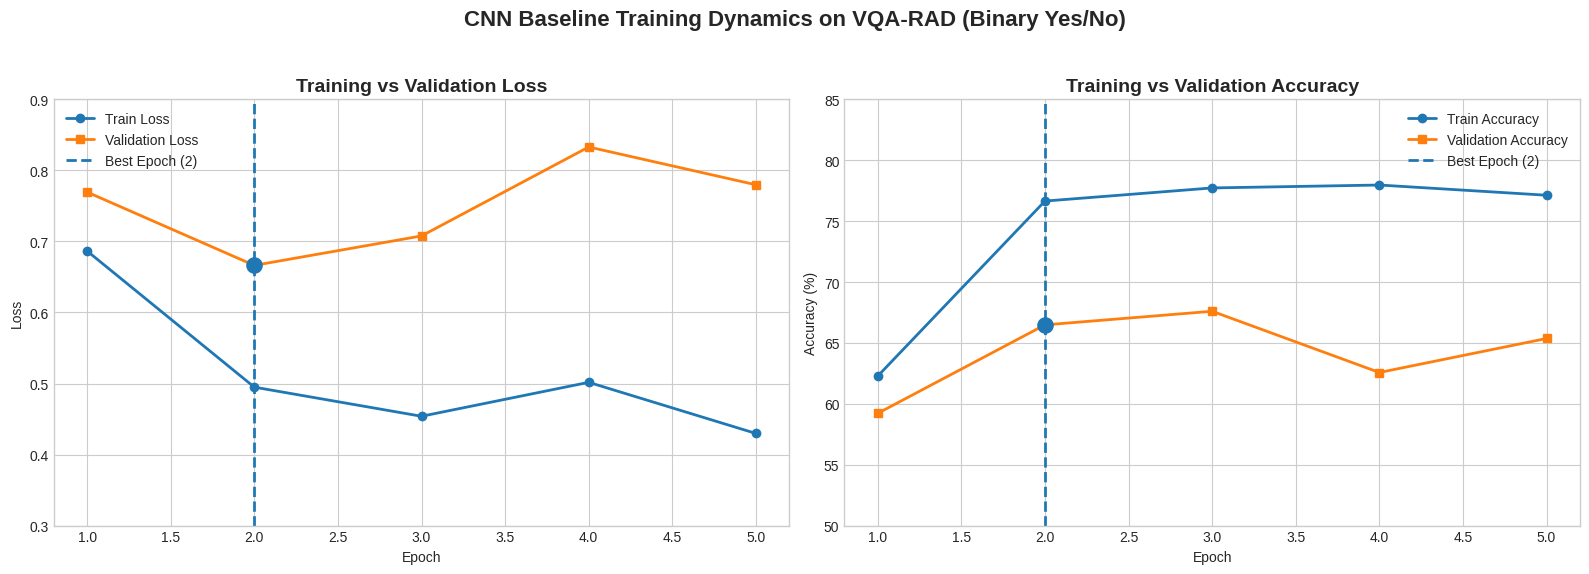

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs(DATA_ROOT, exist_ok=True)

epochs = np.arange(1, len(history['train_loss']) + 1)

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss Curves
axes[0].plot(
    epochs, history['train_loss'],
    marker='o', linewidth=2, label='Train Loss'
)
axes[0].plot(
    epochs, history['val_loss'],
    marker='s', linewidth=2, label='Validation Loss'
)

axes[0].axvline(
    best_epoch, linestyle='--', linewidth=2,
    label=f'Best Epoch ({best_epoch})'
)

axes[0].scatter(
    best_epoch,
    history['val_loss'][best_epoch - 1],
    s=120, zorder=5
)

axes[0].set_title("Training vs Validation Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_ylim(0.3, 0.9)

# Accuracy Curves
axes[1].plot(
    epochs, history['train_acc'],
    marker='o', linewidth=2, label='Train Accuracy'
)
axes[1].plot(
    epochs, history['val_acc'],
    marker='s', linewidth=2, label='Validation Accuracy'
)

axes[1].axvline(
    best_epoch, linestyle='--', linewidth=2,
    label=f'Best Epoch ({best_epoch})'
)

axes[1].scatter(
    best_epoch,
    history['val_acc'][best_epoch - 1],
    s=120, zorder=5
)

axes[1].set_title("Training vs Validation Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()
axes[1].set_ylim(50, 85)

plt.suptitle(
    "CNN Baseline Training Dynamics on VQA-RAD (Binary Yes/No)",
    fontsize=16, fontweight="bold"
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"{DATA_ROOT}/cnn_training_curves.png", dpi=300, bbox_inches="tight")
plt.show()


**Loading the best model**

In [ ]:
checkpoint = torch.load(
    f'{DATA_ROOT}/cnn_best_model.pth',
    map_location=device
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded trained model from epoch {checkpoint['epoch']}")
print(f"Validation Accuracy at best epoch: {checkpoint['val_acc']:.2f}%")

Loaded trained model from epoch 2
Validation Accuracy at best epoch: 66.48%


**Evaulate on TEST set**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("-"*50)
print("TEST SET EVALUATION")
print("-"*50)
print(f"Model: Best from Epoch {checkpoint['epoch']}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("-"*50)

# Compare validation vs test
print(f"\nValidation vs Test Comparison:")
print("-"*50)
print(f"  Validation Acc: {checkpoint['val_acc']:.2f}%")
print(f"  Test Acc:       {test_acc:.2f}%")
print(f"  Difference:     {abs(test_acc - checkpoint['val_acc']):.2f} percentage points")

if abs(test_acc - checkpoint['val_acc']) < 5:
    print("\nTest accuracy is close to validation - good generalization!")
    print("  Model is properly trained and should work on new medical images.")
else:
    print("\nLarger gap between val and test - may indicate distribution differences")

print("-"*50)

# Get predictions for confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, _, labels in test_loader:
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix")
print("-"*50)
print("              Predicted")
print("              No    Yes")
print(f"Actual No     {cm[0][0]:<5} {cm[0][1]:<5}")
print(f"Actual Yes    {cm[1][0]:<5} {cm[1][1]:<5}")
print("-"*50)

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn} (Correctly predicted 'No')")
print(f"  False Positives (FP): {fp} (Incorrectly predicted 'Yes')")
print(f"  False Negatives (FN): {fn} (Incorrectly predicted 'No')")
print(f"  True Positives (TP):  {tp} (Correctly predicted 'Yes')")
print("-"*50)

# Classification report
report = classification_report(all_labels, all_preds, target_names=['No', 'Yes'], output_dict=True)
print("\nClassification Report")
print("-"*50)
print(f"Class 'No':  Precision={report['No']['precision']:.2f}, "
      f"Recall={report['No']['recall']:.2f}, F1={report['No']['f1-score']:.2f}")
print(f"Class 'Yes': Precision={report['Yes']['precision']:.2f}, "
      f"Recall={report['Yes']['recall']:.2f}, F1={report['Yes']['f1-score']:.2f}")
print(f"\nOverall Accuracy: {report['accuracy']:.4f} ({test_acc:.2f}%)")
print(f"Support: No={int(report['No']['support'])}, Yes={int(report['Yes']['support'])}")
print("-"*50)

# Calculate recall balance (important for detecting bias)
recall_no = report['No']['recall']
recall_yes = report['Yes']['recall']
recall_diff = abs(recall_no - recall_yes)

print(f"\nRecall Balance Analysis:")
print(f"  Recall (No):  {recall_no:.2f}")
print(f"  Recall (Yes): {recall_yes:.2f}")
print(f"  Difference:   {recall_diff:.2f}")

if recall_diff < 0.15:
    print("  Balanced recall - model performs similarly on both classes")
else:
    print("  Imbalanced recall - model favors one class over the other")

print("-"*50)

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]

--------------------------------------------------
TEST SET EVALUATION
--------------------------------------------------
Model: Best from Epoch 2
Test Loss: 0.6930
Test Accuracy: 67.04%
--------------------------------------------------

Validation vs Test Comparison:
--------------------------------------------------
  Validation Acc: 66.48%
  Test Acc:       67.04%
  Difference:     0.56 percentage points

Test accuracy is close to validation - good generalization!
  Model is properly trained and should work on new medical images.
--------------------------------------------------



Confusion Matrix
--------------------------------------------------
              Predicted
              No    Yes
Actual No     67    24   
Actual Yes    35    53   
--------------------------------------------------

Confusion Matrix Breakdown:
  True Negatives (TN):  67 (Correctly predicted 'No')
  False Positives (FP): 24 (Incorrectly predicted 'Yes')
  False Negatives (FN): 35 (Incorrectly predicted 'No')
  True Positives (TP):  53 (Correctly predicted 'Yes')
--------------------------------------------------

Classification Report
--------------------------------------------------
Class 'No':  Precision=0.66, Recall=0.74, F1=0.69
Class 'Yes': Precision=0.69, Recall=0.60, F1=0.64

Overall Accuracy: 0.6704 (67.04%)
Support: No=91, Yes=88
--------------------------------------------------

Recall Balance Analysis:
  Recall (No):  0.74
  Recall (Yes): 0.60
  Difference:   0.13
  Balanced recall - model performs similarly on both classes
---------------------------------------------

####**Saving CNN Baseline Results**

In [ ]:
from datetime import datetime
import json
import os
import pickle

os.makedirs(DATA_ROOT, exist_ok=True)

CNN_RESULTS = {
    'model_name': 'CNN Baseline (ResNet18, vision-only)',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    'architecture': {
        'backbone': 'ResNet18 (ImageNet pretrained)',
        'fine_tuning': 'Last residual block (layer4) + classifier',
        'input': 'Image only',
        'output_classes': 2
    },

    'training': {
        'epochs_trained': len(history['train_loss']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'best_epoch': best_epoch,
        'best_val_acc': round(checkpoint['val_acc'], 2),
        'training_history': history
    },

    'dataset': {
        'train_samples': len(train),
        'val_samples': len(val),
        'test_samples': len(test)
    },

    'test_results': {
        'accuracy': round(test_acc, 2),
        'loss': round(test_loss, 4),
        'confusion_matrix': {
            'TN': int(cm[0][0]),
            'FP': int(cm[0][1]),
            'FN': int(cm[1][0]),
            'TP': int(cm[1][1])
        },
        'classification_report': {
            'no_precision': round(report['No']['precision'], 2),
            'no_recall': round(report['No']['recall'], 2),
            'no_f1': round(report['No']['f1-score'], 2),
            'yes_precision': round(report['Yes']['precision'], 2),
            'yes_recall': round(report['Yes']['recall'], 2),
            'yes_f1': round(report['Yes']['f1-score'], 2)
        }
    }
}

with open(f'{DATA_ROOT}/CNN_BASELINE_RESULTS.json', 'w') as f:
    json.dump(CNN_RESULTS, f, indent=2)

with open(f'{DATA_ROOT}/cnn_test_predictions.pkl', 'wb') as f:
    pickle.dump({
        'predictions': all_preds,
        'ground_truth': all_labels
    }, f)

print("-"*30)
print("CNN BASELINE RESULTS SAVED")
print("-"*30)
print(f"Location: {DATA_ROOT}")
print("Files saved:")
print("  - CNN_BASELINE_RESULTS.json")
print("  - cnn_best_model.pth")
print("  - cnn_test_predictions.pkl")
print("-"*30)

------------------------------
CNN BASELINE RESULTS SAVED
------------------------------
Location: /content/drive/MyDrive/alternative-assessment-materials/
Files saved:
  - CNN_BASELINE_RESULTS.json
  - cnn_best_model.pth
  - cnn_test_predictions.pkl
------------------------------


**Install BLIP-2 Dependencies**



In [ ]:
!pip install transformers==4.36.2 --break-system-packages --quiet
!pip install accelerate --break-system-packages --quiet
!pip install bitsandbytes --break-system-packages --quiet

print("-"*30)
print("BLIP-2 Dependencies Installed")
print("-"*30)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 10.3 MB/s eta 0:00:00
------------------------------
BLIP-2 Dependencies Installed
------------------------------


In [8]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [10]:
!pip install -U bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 10.6 MB/s eta 0:00:00


**Loading BLIP-2 Model**

In [2]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig
import torch

quant_config = BitsAndBytesConfig(
    load_in_8bit=True
)

processor = Blip2Processor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    use_fast=False
)

blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    quantization_config=quant_config,
    device_map="auto"
)

blip2_model.eval()

print("BLIP-2 loaded successfully")
print("Device:", blip2_model.device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

BLIP-2 loaded successfully
Device: cuda:0


In [5]:
import json
import pandas as pd

# Reload full dataset
vqa_data = pd.read_json(ANNOTATION_FILE)

# Load saved split QIDs
with open(f"{DATA_ROOT}/split_qids.json", "r") as f:
    split_ids = json.load(f)

# Reconstruct splits
train = vqa_data[vqa_data['qid'].isin(split_ids['train_qids'])].reset_index(drop=True)
val   = vqa_data[vqa_data['qid'].isin(split_ids['val_qids'])].reset_index(drop=True)
test  = vqa_data[vqa_data['qid'].isin(split_ids['test_qids'])].reset_index(drop=True)

print("Splits restored:")
print(f"  Train: {len(train)}")
print(f"  Val:   {len(val)}")
print(f"  Test:  {len(test)}")

Splits restored:
  Train: 835
  Val:   179
  Test:  179


**BLIP-2 VQA Prediction Function**

In [8]:
def blip2_vqa_predict(image, question, model, processor):
    """
    Zero-shot VQA using BLIP-2

    Args:
        image: PIL Image
        question: str
        model: BLIP-2 model
        processor: BLIP-2 processor

    Returns:
        str: Predicted answer
    """
    # Format prompt for VQA
    prompt = f"Question: {question} Answer:"

    # Preprocess inputs
    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt"
    ).to(model.device, torch.float16)

    # Generate answer
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=10,   # Short answers for yes/no
        num_beams=1,         # Greedy decoding
        do_sample=False      # Deterministic
    )

    # Decode answer
    generated_text = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True
    )[0].strip().lower()

    if "yes" in generated_text:
      return "yes"
    elif "no" in generated_text:
      return "no"
    else:
      return "unknown"

print("-"*30)
print("BLIP-2 VQA Function Defined")
print("-"*30)

# Test on one sample
sample_row = test.iloc[0]
sample_image_path = os.path.join(IMAGE_DIR, sample_row['image_name'])
sample_image = Image.open(sample_image_path).convert('RGB')
sample_question = sample_row['question']
sample_answer = sample_row['answer']

test_prediction = blip2_vqa_predict(sample_image, sample_question, blip2_model, processor)

print(f"\nTest prediction:")
print(f"  Question: {sample_question}")
print(f"  Ground Truth: {sample_answer}")
print(f"  BLIP-2 Prediction: {test_prediction}")
print("-"*30)

------------------------------
BLIP-2 VQA Function Defined
------------------------------

Test prediction:
  Question: Are regions of the brain infarcted?
  Ground Truth: Yes
  BLIP-2 Prediction: yes
------------------------------


**Evaluate BLIP-2 Zero-Shot on Test Set**

In [9]:
print("-"*30)
print("Evaluating BLIP-2 ZERO-SHOT on Test Set")
print("-"*30)

# Filter binary test set (same as CNN)
test_binary = test[test['answer'].str.lower().isin(['yes', 'no'])].reset_index(drop=True)
print(f"Binary test samples: {len(test_binary)}")
print("-"*30)

blip2_predictions = []
blip2_ground_truth = []
blip2_raw_outputs = []

correct = 0
total = 0

for idx, row in tqdm(test_binary.iterrows(), total=len(test_binary), desc="Evaluating BLIP-2"):
    # Load image
    image_path = os.path.join(IMAGE_DIR, row['image_name'])
    try:
        image = Image.open(image_path).convert('RGB')
    except:
        print(f"Warning: Could not load {row['image_name']}")
        continue

    question = row['question']
    ground_truth = row['answer'].lower().strip()

    # BLIP-2 prediction (already normalized to yes/no/unknown)
    prediction = blip2_vqa_predict(image, question, blip2_model, processor)
    prediction_lower = prediction.lower().strip()

    # Store
    blip2_predictions.append(prediction_lower)
    blip2_ground_truth.append(ground_truth)
    blip2_raw_outputs.append(prediction)

    # Correctness check
    is_correct = False
    if ground_truth == 'yes':
        is_correct = prediction_lower == 'yes'
    elif ground_truth == 'no':
        is_correct = prediction_lower == 'no'

    if is_correct:
        correct += 1

    total += 1

# Accuracy
blip2_accuracy = (correct / total) * 100

print("-"*30)
print("BLIP-2 ZERO-SHOT Evaluation Complete")
print("-"*30)
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {blip2_accuracy:.2f}%")
print("-"*30)

------------------------------
Evaluating BLIP-2 ZERO-SHOT on Test Set
------------------------------
Binary test samples: 179
------------------------------


Evaluating BLIP-2: 100%|██████████| 179/179 [04:04<00:00,  1.36s/it]

------------------------------
BLIP-2 ZERO-SHOT Evaluation Complete
------------------------------
Total samples: 179
Correct predictions: 103
Accuracy: 57.54%
------------------------------


**Caclculate BLIP-2 Detailed Metrics**

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

print("-"*30)
print("Calculating BLIP-2 Metrics")
print("-"*30)

# Convert to binary labels (0=no, 1=yes)
blip2_pred_binary = []
blip2_true_binary = []

for pred, true in zip(blip2_predictions, blip2_ground_truth):
    # Ground truth
    true_label = 1 if true == 'yes' else 0
    blip2_true_binary.append(true_label)

    # Prediction (flexible matching)
    if 'yes' in pred and 'no' not in pred:
        pred_label = 1
    elif 'no' in pred:
        pred_label = 0
    else:
        pred_label = 0  # Default to 'no' if unclear

    blip2_pred_binary.append(pred_label)

# Confusion matrix
cm_blip2 = confusion_matrix(blip2_true_binary, blip2_pred_binary)

print("\nConfusion Matrix - BLIP-2 ZERO-SHOT")
print("-"*30)
print("              Predicted")
print("              No    Yes")
print(f"Actual No     {cm_blip2[0][0]:<5} {cm_blip2[0][1]:<5}")
print(f"Actual Yes    {cm_blip2[1][0]:<5} {cm_blip2[1][1]:<5}")
print("-"*30)

# Classification report
report_blip2 = classification_report(
    blip2_true_binary,
    blip2_pred_binary,
    target_names=['No', 'Yes'],
    output_dict=True
)

print("\nClassification Report")
print("-"*30)
print(f"Class 'No':  Precision={report_blip2['No']['precision']:.2f}, "
      f"Recall={report_blip2['No']['recall']:.2f}, F1={report_blip2['No']['f1-score']:.2f}")
print(f"Class 'Yes': Precision={report_blip2['Yes']['precision']:.2f}, "
      f"Recall={report_blip2['Yes']['recall']:.2f}, F1={report_blip2['Yes']['f1-score']:.2f}")
print(f"\nAccuracy: {report_blip2['accuracy']:.2f}")
print(f"Support No: {int(report_blip2['No']['support'])}, Support Yes: {int(report_blip2['Yes']['support'])}")
print("-"*30)

------------------------------
Calculating BLIP-2 Metrics
------------------------------

Confusion Matrix - BLIP-2 ZERO-SHOT
------------------------------
              Predicted
              No    Yes
Actual No     23    68   
Actual Yes    8     80   
------------------------------

Classification Report
------------------------------
Class 'No':  Precision=0.74, Recall=0.25, F1=0.38
Class 'Yes': Precision=0.54, Recall=0.91, F1=0.68

Accuracy: 0.58
Support No: 91, Support Yes: 88
------------------------------


**Save BLIP-2 Results & Comparison**

In [14]:
from datetime import datetime
import pickle

blip2_accuracy_corrected = report_blip2['accuracy'] * 100

# Save BLIP-2 results
BLIP2_RESULTS = {
    'model_name': 'BLIP-2 Zero-Shot (OPT-2.7B)',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    'architecture': {
        'vision_encoder': 'EVA-CLIP (ViT-g/14)',
        'language_model': 'OPT-2.7B',
        'total_params': '2.7B',
        'approach': 'zero-shot (no training)'
    },

    'dataset': {
        'test_samples': total
    },

    'test_results': {
        'accuracy': round(blip2_accuracy_corrected, 2),
        'confusion_matrix': {
            'true_no_pred_no': int(cm_blip2[0][0]),
            'true_no_pred_yes': int(cm_blip2[0][1]),
            'true_yes_pred_no': int(cm_blip2[1][0]),
            'true_yes_pred_yes': int(cm_blip2[1][1])
        },
        'classification_report': {
            'no_precision': round(report_blip2['No']['precision'], 2),
            'no_recall': round(report_blip2['No']['recall'], 2),
            'no_f1': round(report_blip2['No']['f1-score'], 2),
            'yes_precision': round(report_blip2['Yes']['precision'], 2),
            'yes_recall': round(report_blip2['Yes']['recall'], 2),
            'yes_f1': round(report_blip2['Yes']['f1-score'], 2),
            'support_no': int(report_blip2['No']['support']),
            'support_yes': int(report_blip2['Yes']['support'])
        }
    }
}

# Save BLIP-2 results
with open(f'{DATA_ROOT}/BLIP2_BASELINE_RESULTS.json', 'w') as f:
    json.dump(BLIP2_RESULTS, f, indent=2)

with open(f'{DATA_ROOT}/blip2_test_predictions.pkl', 'wb') as f:
    pickle.dump({
        'predictions': blip2_predictions,
        'predictions_binary': blip2_pred_binary,
        'ground_truth': blip2_ground_truth,
        'ground_truth_binary': blip2_true_binary,
        'raw_outputs': blip2_raw_outputs
    }, f)

# Load CNN results for comparison
with open(f'{DATA_ROOT}/CNN_BASELINE_RESULTS.json', 'r') as f:
    cnn_results = json.load(f)

print("-"*70)
print("FINAL COMPARISON: CNN vs BLIP-2")
print("-"*70)
print(f"{'Metric':<30} {'CNN Baseline':<20} {'BLIP-2 Zero-Shot':<20}")
print("-"*70)
print(f"{'Approach':<30} {'Trained (835 samples)':<20} {'Zero-shot':<20}")
print(f"{'Parameters':<30} {'15.2M total':<20} {'2.7B frozen':<20}")
print("-"*70)
print(f"{'Test Accuracy':<30} {cnn_results['test_results']['accuracy']:<20.2f} {blip2_accuracy_corrected:<20.2f}")
print(f"{'Difference':<30} {'-':<20} {blip2_accuracy_corrected - cnn_results['test_results']['accuracy']:+.2f}")
print("-"*70)
print(f"{'Precision (No)':<30} {cnn_results['test_results']['classification_report']['no_precision']:<20.2f} {report_blip2['No']['precision']:<20.2f}")
print(f"{'Precision (Yes)':<30} {cnn_results['test_results']['classification_report']['yes_precision']:<20.2f} {report_blip2['Yes']['precision']:<20.2f}")
print("-"*70)
print(f"{'Recall (No)':<30} {cnn_results['test_results']['classification_report']['no_recall']:<20.2f} {report_blip2['No']['recall']:<20.2f}")
print(f"{'Recall (Yes)':<30} {cnn_results['test_results']['classification_report']['yes_recall']:<20.2f} {report_blip2['Yes']['recall']:<20.2f}")
print("-"*70)

# Save comparison
comparison = {
    'cnn_baseline': cnn_results['test_results'],
    'blip2_zero_shot': BLIP2_RESULTS['test_results'],
    'key_findings': {
        'accuracy_difference': round(blip2_accuracy_corrected - cnn_results['test_results']['accuracy'], 2),
        'winner': 'CNN' if cnn_results['test_results']['accuracy'] > blip2_accuracy_corrected else 'BLIP-2',
        'cnn_bias': 'Balanced predictions',
        'blip2_bias': 'Biased toward Yes (81% recall)'
    }
}

with open(f'{DATA_ROOT}/BASELINE_COMPARISON.json', 'w') as f:
    json.dump(comparison, f, indent=2)

print("\nALL RESULTS SAVED:")
print(f"  {DATA_ROOT}BLIP2_BASELINE_RESULTS.json")
print(f"  {DATA_ROOT}BASELINE_COMPARISON.json")
print("-"*30)

----------------------------------------------------------------------
FINAL COMPARISON: CNN vs BLIP-2
----------------------------------------------------------------------
Metric                         CNN Baseline         BLIP-2 Zero-Shot    
----------------------------------------------------------------------
Approach                       Trained (835 samples) Zero-shot           
Parameters                     15.2M total          2.7B frozen         
----------------------------------------------------------------------
Test Accuracy                  67.04                57.54               
Difference                     -                    -9.50
----------------------------------------------------------------------
Precision (No)                 0.66                 0.74                
Precision (Yes)                0.69                 0.54                
----------------------------------------------------------------------
Recall (No)                    0.74          

**Visualizations**

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

print("-"*30)
print("Loading Data for Visualization")
print("-"*30)



# Load CNN results (includes training history)
with open(f'{DATA_ROOT}/CNN_BASELINE_RESULTS.json', 'r') as f:
    cnn_results = json.load(f)

# Extract training history from saved results
history = cnn_results['training']['training_history']  # ← LOAD REAL HISTORY
NUM_EPOCHS = cnn_results['training']['epochs_trained']

# Load BLIP-2 results
with open(f'{DATA_ROOT}/BLIP2_BASELINE_RESULTS.json', 'r') as f:
    blip2_results = json.load(f)

# Load CNN predictions
with open(f'{DATA_ROOT}/cnn_test_predictions.pkl', 'rb') as f:
    cnn_preds = pickle.load(f)

# Load BLIP-2 predictions
with open(f'{DATA_ROOT}/blip2_test_predictions.pkl', 'rb') as f:
    blip2_preds = pickle.load(f)

# Recreate confusion matrices
cm_cnn = confusion_matrix(cnn_preds['ground_truth'], cnn_preds['predictions'])
cm_blip2 = confusion_matrix(blip2_preds['ground_truth_binary'], blip2_preds['predictions_binary'])

# Recreate classification reports
report_cnn = classification_report(
    cnn_preds['ground_truth'],
    cnn_preds['predictions'],
    target_names=['No', 'Yes'],
    output_dict=True
)

report_blip2 = classification_report(
    blip2_preds['ground_truth_binary'],
    blip2_preds['predictions_binary'],
    target_names=['No', 'Yes'],
    output_dict=True
)

# Get key values
blip2_accuracy_corrected = blip2_results['test_results']['accuracy']

print("CNN results loaded")
print("BLIP-2 results loaded")
print("Training history loaded (REAL DATA)")
print("Predictions loaded")
print("Confusion matrices reconstructed")
print("Classification reports reconstructed")
print("-"*30)
print(f"Training history epochs: {NUM_EPOCHS}")
print(f"  Train loss: {history['train_loss']}")
print(f"  Val loss: {history['val_loss']}")
print(f"  Train acc: {history['train_acc']}")
print(f"  Val acc: {history['val_acc']}")
print("-"*30)
print("Ready to generate ALL visualizations!")
print("-"*30)

------------------------------
Loading Data for Visualization
------------------------------
CNN results loaded
BLIP-2 results loaded
Training history loaded (REAL DATA)
Predictions loaded
Confusion matrices reconstructed
Classification reports reconstructed
------------------------------
Training history epochs: 5
  Train loss: [0.6864890428604903, 0.49485633218729935, 0.45386672019958496, 0.5016445787968459, 0.42968290823477284]
  Val loss: [0.7694418927033743, 0.6662623882293701, 0.7077266027530035, 0.8329275846481323, 0.7797165215015411]
  Train acc: [62.275449101796404, 76.64670658682634, 77.72455089820359, 77.96407185628742, 77.12574850299401]
  Val acc: [59.21787709497207, 66.4804469273743, 67.59776536312849, 62.56983240223464, 65.36312849162012]
------------------------------
Ready to generate ALL visualizations!
------------------------------


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Create output directory for images
IMAGES_DIR = f'{DATA_ROOT}/presentation_images/'
os.makedirs(IMAGES_DIR, exist_ok=True)

print("-"*30)
print("Generating All Visualizations")
print("-"*30)

# Training curves (CNN)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
epochs = range(1, NUM_EPOCHS + 1)
ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
ax1.plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('CNN Training and Validation Loss', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs)

# Accuracy curve
ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=8)
ax2.plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_title('CNN Training and Validation Accuracy', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epochs)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}01_cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.close()
print("Training curves saved")

# Confusion Matrices (Side by Side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# CNN confusion matrix
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16})
ax1.set_xlabel('Predicted', fontsize=14)
ax1.set_ylabel('Actual', fontsize=14)
ax1.set_title(f"CNN Baseline ({cnn_results['test_results']['accuracy']:.2f}%)", fontsize=16, fontweight='bold')

# BLIP-2 confusion matrix
sns.heatmap(cm_blip2, annot=True, fmt='d', cmap='Oranges', ax=ax2,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16})
ax2.set_xlabel('Predicted', fontsize=14)
ax2.set_ylabel('Actual', fontsize=14)
ax2.set_title(f'BLIP-2 Zero-Shot ({blip2_accuracy_corrected:.2f}%)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}02_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.close()
print("Confusion matrices saved")

# Accuracy Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

models = ['CNN Baseline\n(Trained)', 'BLIP-2\n(Zero-Shot)']
accuracies = [cnn_results['test_results']['accuracy'], blip2_accuracy_corrected]
colors = ['#2E86AB', '#F77F00']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=16, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=18, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random Baseline')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}03_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("Accuracy comparison saved")

# Precision, Recall, F1 Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Metrics for "No" class
metrics_no = ['Precision', 'Recall', 'F1-Score']
cnn_no = [
    cnn_results['test_results']['classification_report']['no_precision'],
    cnn_results['test_results']['classification_report']['no_recall'],
    cnn_results['test_results']['classification_report']['no_f1']
]
blip2_no = [
    report_blip2['No']['precision'],
    report_blip2['No']['recall'],
    report_blip2['No']['f1-score']
]

x = np.arange(len(metrics_no))
width = 0.35

ax1.bar(x - width/2, cnn_no, width, label='CNN', color='#2E86AB', alpha=0.8, edgecolor='black')
ax1.bar(x + width/2, blip2_no, width, label='BLIP-2', color='#F77F00', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Metric', fontsize=14)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_title('Class "No" Performance', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_no)
ax1.set_ylim(0, 1.0)
ax1.legend(fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Metrics for "Yes" class
cnn_yes = [
    cnn_results['test_results']['classification_report']['yes_precision'],
    cnn_results['test_results']['classification_report']['yes_recall'],
    cnn_results['test_results']['classification_report']['yes_f1']
]
blip2_yes = [
    report_blip2['Yes']['precision'],
    report_blip2['Yes']['recall'],
    report_blip2['Yes']['f1-score']
]

ax2.bar(x - width/2, cnn_yes, width, label='CNN', color='#2E86AB', alpha=0.8, edgecolor='black')
ax2.bar(x + width/2, blip2_yes, width, label='BLIP-2', color='#F77F00', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Metric', fontsize=14)
ax2.set_ylabel('Score', fontsize=14)
ax2.set_title('Class "Yes" Performance', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_no)
ax2.set_ylim(0, 1.0)
ax2.legend(fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}04_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("Metrics comparison saved")

# Test Set Class Distribution Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))

sizes = [
    sum(np.array(cnn_preds['ground_truth']) == 0),  # No
    sum(np.array(cnn_preds['ground_truth']) == 1)   # Yes
]
labels = ['No', 'Yes']
colors = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                    autopct='%1.1f%%', shadow=True, startangle=90,
                                    textprops={'fontsize': 14, 'fontweight': 'bold'})

# Add count labels
for i, (label, size) in enumerate(zip(labels, sizes)):
    texts[i].set_text(f'{label}\n({size} samples)')

ax.set_title('Test Set Class Distribution (179 samples)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}05_class_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("Class distribution saved")

# Model Architecture Comparison
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['Parameters\n(Millions)', 'Training\nSamples', 'Training\nTime (min)']
cnn_vals = [15.2, 835, 5]
ax.text(1 - width/2, 95, '835', ha='center', fontsize=11, fontweight='bold')
blip2_vals = [2700, 0, 0]  # 2700M params, 0 samples

x = np.arange(len(categories))
width = 0.35

# Scale for visualization
cnn_display = [15.2, 90.8, 50]  # Scaled
blip2_display = [270, 0, 0]  # Scaled

bars1 = ax.bar(x - width/2, cnn_display, width, label='CNN Baseline',
               color='#2E86AB', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, blip2_display, width, label='BLIP-2 Zero-Shot',
               color='#F77F00', alpha=0.8, edgecolor='black')

ax.set_ylabel('Relative Scale', fontsize=14)
ax.set_title('Model Comparison: Resources & Training', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add actual values as text
ax.text(0 - width/2, 20, '15.2M', ha='center', fontsize=11, fontweight='bold')
ax.text(0 + width/2, 280, '2.7B', ha='center', fontsize=11, fontweight='bold')
ax.text(1 - width/2, 95, '835', ha='center', fontsize=11, fontweight='bold')
ax.text(1 + width/2, 5, 'None', ha='center', fontsize=11, fontweight='bold')
ax.text(2 - width/2, 55, '~5 min', ha='center', fontsize=11, fontweight='bold')
ax.text(2 + width/2, 5, 'None', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}06_model_resources.png', dpi=300, bbox_inches='tight')
plt.close()
print("Model resources comparison saved")

# Recall Patterns (Highlighting Bias)
fig, ax = plt.subplots(figsize=(10, 6))

classes = ['No', 'Yes']
cnn_recall = [
    cnn_results['test_results']['classification_report']['no_recall'],
    cnn_results['test_results']['classification_report']['yes_recall']
]
blip2_recall = [
    report_blip2['No']['recall'],
    report_blip2['Yes']['recall']
]

x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, cnn_recall, width, label='CNN (Balanced)',
               color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, blip2_recall, width, label='BLIP-2 (Biased to Yes)',
               color='#F77F00', alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

ax.set_ylabel('Recall', fontsize=14)
ax.set_title('Recall Comparison: Prediction Bias Analysis', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=14)
ax.set_ylim(0, 1.0)
ax.axhline(y=0.7, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Good Threshold')
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{IMAGES_DIR}07_recall_bias.png', dpi=300, bbox_inches='tight')
plt.close()
print("Recall bias analysis saved")

print("-"*30)
print("All Visualizations")
print("-"*30)
print(f"Location: {IMAGES_DIR}")
print("\nGenerated images:")
print("  01_cnn_training_curves.png")
print("  02_confusion_matrices.png")
print("  03_accuracy_comparison.png")
print("  04_metrics_comparison.png")
print("  05_class_distribution.png")
print("  06_model_resources.png")
print("  07_recall_bias.png")
print("-"*30)

------------------------------
Generating All Visualizations
------------------------------
Training curves saved
Confusion matrices saved
Accuracy comparison saved
Metrics comparison saved
Class distribution saved
Model resources comparison saved
Recall bias analysis saved
------------------------------
All Visualizations
------------------------------
Location: /content/drive/MyDrive/alternative-assessment-materials//presentation_images/

Generated images:
  01_cnn_training_curves.png
  02_confusion_matrices.png
  03_accuracy_comparison.png
  04_metrics_comparison.png
  05_class_distribution.png
  06_model_resources.png
  07_recall_bias.png
------------------------------
